In [1]:
# prepare the IMDB data
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000 # number of words to consider as features
max_len = 500 # cut texts after this number of words (among top max_features most common words)
print('Loading data...')

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

D:\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


In [3]:
# train and evaluate a simple 1D convnet
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model=Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])
history=model.fit(x_train,y_train,epochs=10,batch_size=128,validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
_________________________________________________________________


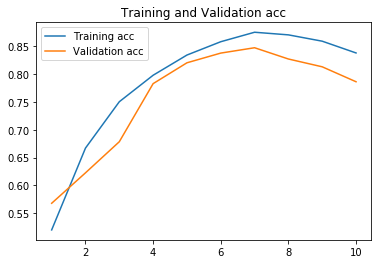

In [4]:
import matplotlib.pyplot as plt

acc=history.history['acc']
val_acc=history.history['val_acc']
epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,label='Training acc')
plt.plot(epochs,val_acc,label='Validation acc')
plt.title('Training and Validation acc')
plt.legend()
plt.show()

In [5]:
# Build a CNN-RNN model for the Jena dataset
# prepare the data
import os
import numpy as np

data_dir='/Users/think/Downloads/jena_climate'
fname=os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f=open(fname,encoding='utf8')
data=f.read()
f.close()

lines=data.split('\n')
header=lines[0].split(',')
lines=lines[1:]

float_data=np.zeros((len(lines),len(header)-1))
for i,line in enumerate(lines):
    values=[float(x) for x in line.split(',')[1:]]
    float_data[i,:]=values
    
mean=float_data[:200000].mean(axis=0)
float_data -= mean
std=float_data[:200000].std(axis=0)
float_data /= std

# create a generator yielding timeseries and targets
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index=len(data)-delay-1
    i=min_index+lookback
    while 1:
        if shuffle:
            # 随机生成一个数组，最小值为min_index+lookback，最大值为max_index，长度为batch_size
            rows=np.random.randint(min_index+lookback, max_index, size=batch_size)
        else:
            if i+batch_size>=max_index:
                i=min_index+lookback
            rows=np.arange(i,min(i+batch_size, max_index))
            i += len(rows)
        
        samples=np.zeros((len(rows), lookback//step, data.shape[-1]))
        targets=np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices=range(rows[j]-lookback, rows[j], step)
            samples[j]=data[indices]
            targets[j]=data[rows[j]+delay][1]
        yield samples, targets

lookback=720
step=3
delay=144
batch_size=128

train_gen=generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)
val_gen=generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, step=step, batch_size=batch_size)
test_gen=generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, step=step, batch_size=batch_size)

val_steps=(300000-200001-lookback)//batch_size
test_steps=(len(float_data)-300001-lookback)//batch_size

In [9]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model=Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history=model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 81s 163ms/step - loss: 0.3375 - val_loss: 0.3166
Epoch 2/20
500/500 [===============

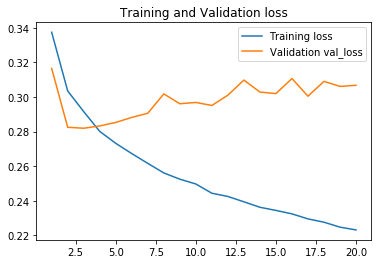

In [12]:
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(loss)+1)

plt.plot(epochs,loss,label='Training loss')
plt.plot(epochs,val_loss,label='Validation val_loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()